<a href="https://colab.research.google.com/github/Kishore-Vijayakumar/Dataset_4/blob/main/TurmericPlant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/TurmericPlant"
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 64
SEED = 42

In [ ]:
MAX_SAMPLES_PER_CLASS = None

In [ ]:

!pip install tensorflow scikit-learn scikit-plot --quiet

In [ ]:



import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns, time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(128,128),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(128,128),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 694 images belonging to 4 classes.
Found 171 images belonging to 4 classes.


In [ ]:

# CNN Model (Functional API + MobileNetV2)
# ==========================================
base_model = MobileNetV2(input_shape=(128,128,3), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = Input(shape=(128,128,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

#  Training CNN
# ==========================================
early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

start_time = time.time()
history = model.fit(
    train_gen,
    epochs=3,
    validation_data=val_gen,
    callbacks=[early_stop],
    verbose=1
)
train_time = time.time() - start_time


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
11/11 ━━━━━━━━━━━━━━━━━━━━ 391s 35s/step - accuracy: 0.5083 - loss: 1.3189 - val_accuracy: 0.8947 - val_loss: 0.3798
Epoch 2/3
11/11 ━━━━━━━━━━━━━━━━━━━━ 131s 12s/step - accuracy: 0.8810 - loss: 0.3957 - val_accuracy: 0.9298 - val_loss: 0.2388
Epoch 3/3
11/11 ━━━━━━━━━━━━━━━━━━━━ 119s 11s/step - accuracy: 0.9244 - loss: 0.2403 - val_accuracy: 0.9240 - val_loss: 0.2211


In [ ]:
algorithms_preds = {}   # store predictions
algorithms_metrics = [] # store metrics

In [ ]:

#  Evaluate CNN
# ==========================================
val_gen.reset()
preds = model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
algorithms_preds['CNN'] = y_pred

cnn_acc = accuracy_score(y_true, y_pred)
cnn_f1 = f1_score(y_true, y_pred, average='macro')
cnn_prec = precision_score(y_true, y_pred, average='macro')
cnn_rec = recall_score(y_true, y_pred, average='macro')

algorithms_metrics.append({
    "Algorithm": "CNN",
    "Accuracy": cnn_acc,
    "Precision": cnn_prec,
    "Recall": cnn_rec,
    "F1": cnn_f1,
    "TrainTime": train_time/60
})

print("\n CNN Metrics:")
print(f"Accuracy: {cnn_acc:.4f}, Precision: {cnn_prec:.4f}, Recall: {cnn_rec:.4f}, F1: {cnn_f1:.4f}, Training Time: {train_time/60:.2f} mins")


3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 7s/step

 CNN Metrics:
Accuracy: 0.9240, Precision: 0.9241, Recall: 0.9218, F1: 0.9220, Training Time: 12.04 mins


In [ ]:

# Feature Extraction for Classical ML
# ==========================================
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

X_train = feature_extractor.predict(train_gen)
X_val = feature_extractor.predict(val_gen)
y_train = train_gen.classes
y_val = val_gen.classes

11/11 ━━━━━━━━━━━━━━━━━━━━ 107s 9s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step


In [ ]:

#  Classical ML Models
# ==========================================
models_list = {
    "SVM": SVC(kernel='rbf', gamma='scale'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

In [ ]:
results = []
import time
for name, clf in models_list.items():
    print(f"\n Training {name}...")

    clf.fit(X_train, y_train)
    start_time = time.time()
    y_pred = clf.predict(X_val)
    end_time = time.time()
    algorithms_preds[name] = y_pred

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro',zero_division=0)
    prec = precision_score(y_val, y_pred, average='macro',zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro',zero_division=0)
    algorithms_metrics.append({
        "Algorithm": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "TrainTime": end_time-start_time
    })

    results.append([name, acc, prec, rec, f1])


 Training SVM...

 Training Random Forest...

 Training KNN...


In [ ]:
# Adding CNN metrics
results.append(["CNN", cnn_acc, cnn_prec, cnn_rec, cnn_f1])
df_results = pd.DataFrame(results, columns=["Algorithm", "Accuracy", "Precision", "Recall", "F1"])
print("\n---  Final Results ---")
print(df_results)


---  Final Results ---
       Algorithm  Accuracy  Precision    Recall        F1
0            SVM  0.228070   0.344889  0.211054  0.152434
1  Random Forest  0.263158   0.267740  0.258404  0.256762
2            KNN  0.228070   0.242739  0.223263  0.226642
3            CNN  0.923977   0.924094  0.921842  0.921952


In [ ]:
# Converting to DataFrame
df_results = pd.DataFrame(algorithms_metrics)
print("\n--- Evaluation Metrics ---")
print(df_results)


--- Evaluation Metrics ---
       Algorithm  Accuracy  Precision    Recall        F1  TrainTime
0            CNN  0.923977   0.924094  0.921842  0.921952  12.035619
1            SVM  0.228070   0.344889  0.211054  0.152434   0.015793
2  Random Forest  0.263158   0.267740  0.258404  0.256762   0.010968
3            KNN  0.228070   0.242739  0.223263  0.226642   0.090052


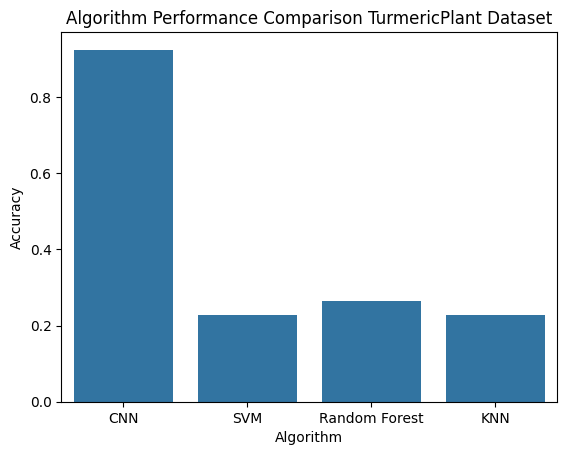

In [ ]:
# Plot comparison
sns.barplot(x="Algorithm", y="Accuracy", data=df_results)
plt.title("Algorithm Performance Comparison TurmericPlant Dataset")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score


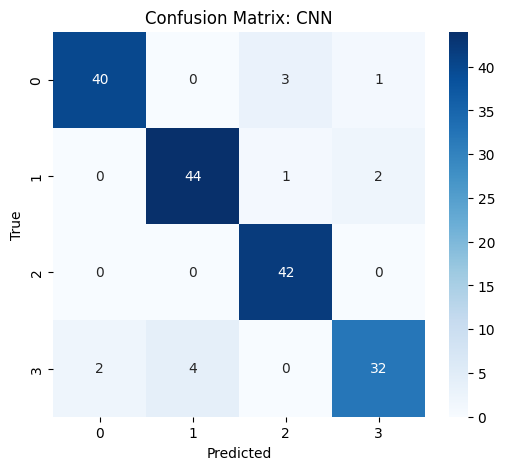

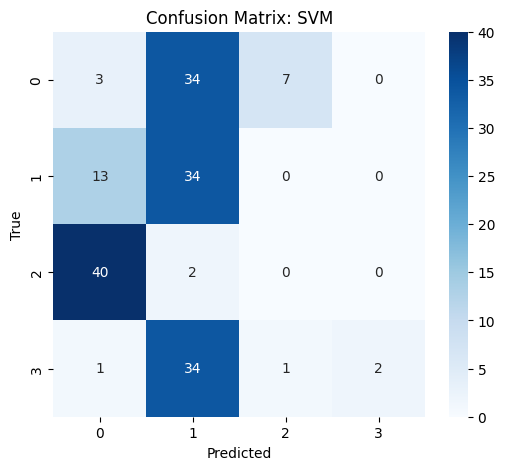

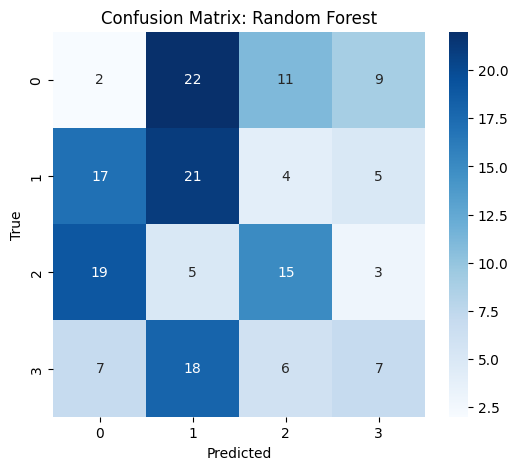

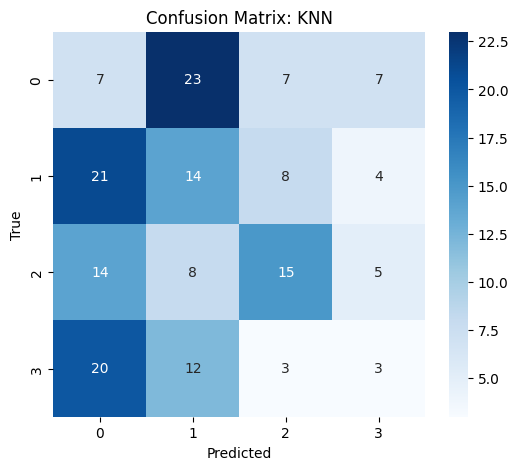

In [ ]:
# Confusion Matrices
# ------------------------------------------------
for algo, preds in algorithms_preds.items():
    cm = confusion_matrix(y_val, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {algo}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

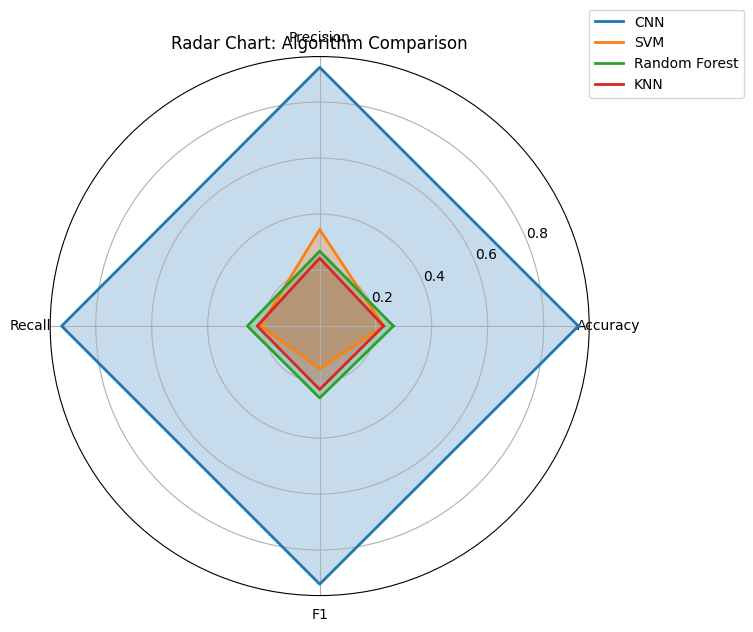

In [ ]:
 #Radar Chart (Accuracy, Precision, Recall, F1)
# ------------------------------------------------
from math import pi
categories = ['Accuracy','Precision','Recall','F1']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

for i, row in df_results.iterrows():
    values = [row[cat] for cat in categories]
    values += values[:1]  # complete loop
    ax.plot(angles, values, linewidth=2, label=row['Algorithm'])
    ax.fill(angles, values, alpha=0.25)

plt.xticks(angles[:-1], categories)
plt.title("Radar Chart: Algorithm Comparison")
plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.1))
plt.show()

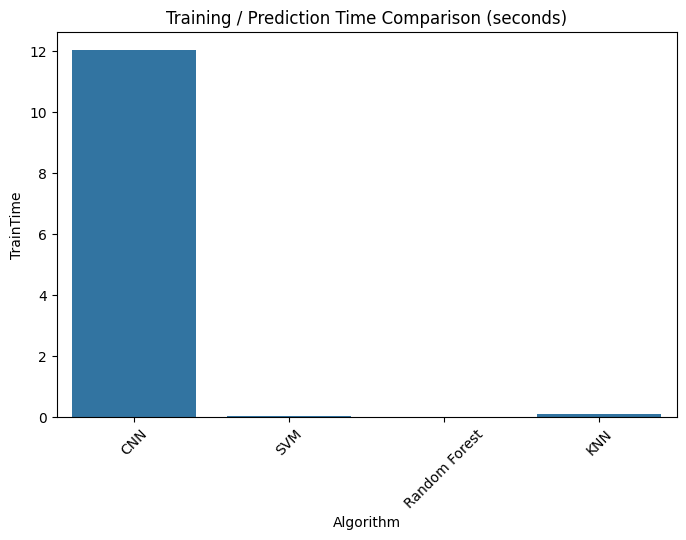

In [ ]:
#  Training Time Bar
# ------------------------------------------------
plt.figure(figsize=(8,5))
sns.barplot(x='Algorithm', y='TrainTime', data=df_results)
plt.title("Training / Prediction Time Comparison (seconds)")
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# ---------------------------------------------
# Prepare labels for ROC (one-hot encoding)
# ---------------------------------------------
# Get all class labels
y_val = val_gen.classes

n_classes = len(np.unique(y_val))
y_val_bin = label_binarize(y_val, classes=range(n_classes))

plt.figure(figsize=(12,8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step


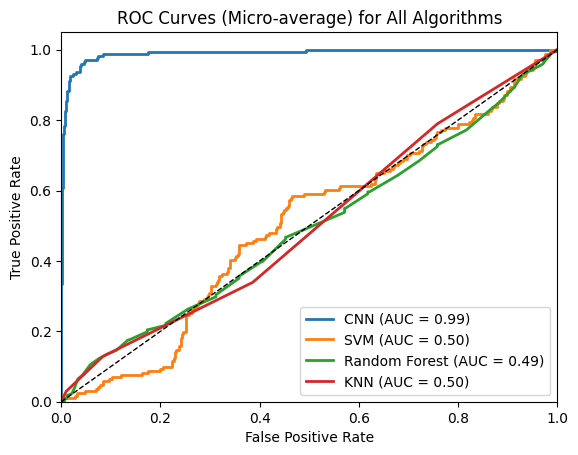

In [ ]:
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'])
algorithm_list = ["CNN", "SVM", "Random Forest", "KNN"]

for algo in algorithm_list:
    y_score = algorithms_preds[algo]

    # For CNN, preds are probabilities
    if algo == "CNN":
        y_score = model.predict(val_gen)

    # For classical ML, need probability estimates
    else:
        if hasattr(models_list[algo], "predict_proba"):
            y_score = models_list[algo].predict_proba(X_val)
        else:
            # Decision function as probability substitute for SVM
            y_score = models_list[algo].decision_function(X_val)
            # If binary, reshape
            if n_classes == 2 and y_score.ndim == 1:
                y_score = np.vstack([1 - y_score, y_score]).T

    # Compute ROC and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"], label=f'{algo} (AUC = {roc_auc["micro"]:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Micro-average) for All Algorithms')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the evaluation metrics to CSV
df_results.to_csv("evaluation_metrics_turmeric.csv", index=False)
print("Evaluation metrics saved as 'evaluation_metrics.csv'")

Evaluation metrics saved as 'evaluation_metrics.csv'


In [ ]:
# Save entire model in HDF5 format
model.save("TurmericPlant.h5")
print(" CNN model saved as 'TurmericPlant.h5'")


 CNN model saved as 'TurmericPlant.h5'
